<h1 style="font-size: 300%">Titanic survival prediction</h1>
Hans Konings, December 2025

This notebook aims at predicting the survivability of people who were on the titanic during its disasterous sinking by applying decision trees. The main advantage of decision trees is that humans can easily understand and reproduce the sequence of decisions taken by the model to predict the target, which makes it one of the most transparent machine learning algorithms available.

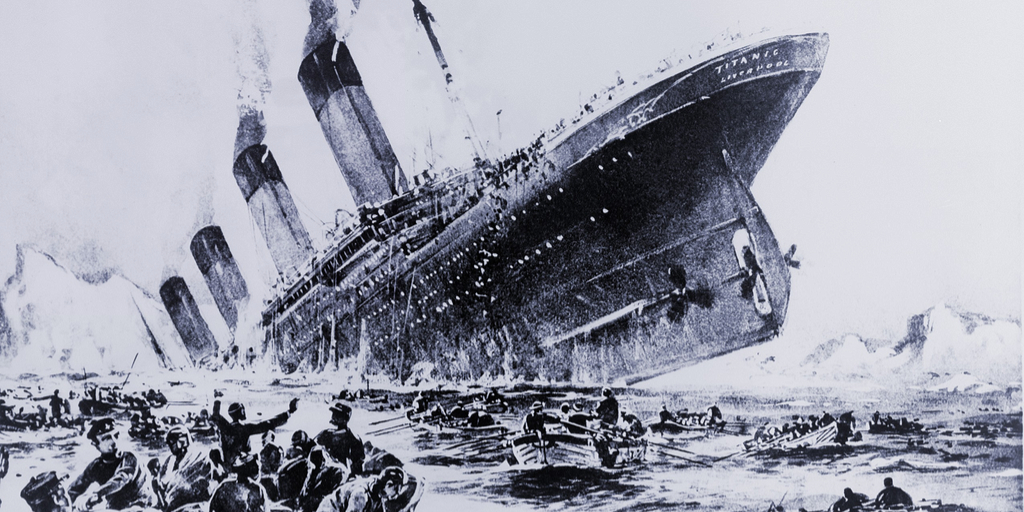


In [11]:
import sklearn
import pandas
import seaborn

print("scikit-learn version:", sklearn.__version__)     # 1.1.3
print("pandas version:", pandas.__version__)            # 1.5.1
print("seaborn version:", seaborn.__version__)          # 0.12.1

scikit-learn version: 1.6.1
pandas version: 2.2.2
seaborn version: 0.13.2


# Data provisioning

The first thing to do is loading the data from the csv file. We get a notion how the data looks like by using the .sample method.


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
df = pandas.read_csv("/content/drive/MyDrive/Colab Notebooks/titanic_ex1/titanic.csv")
df.sample(5)

,pnumber,pclass,survived,name,age,embarked,home.dest,room,ticket,boat,sex
610,611,3rd,0,"Adahl, Mr Mauritz Nils Martin",30.0,Southampton,"Asarum, Sweden Brooklyn, NY",NaN,7076,-72,male
1214,1215,3rd,0,"Skoog, Mr William",NaN,NaN,NaN,NaN,NaN,NaN,male
330,331,2nd,0,"Baimbrigge, Mr Charles R.",23.0,Southampton,Guernsey,NaN,NaN,NaN,male
1278,1279,3rd,0,"Van Impe, Mrs Jean Baptiste",NaN,NaN,NaN,NaN,NaN,NaN,female
786,787,3rd,0,"Econovic, Mr Joso",NaN,Southampton,Austria-Hungary,NaN,NaN,NaN,male


The sample shows a lot of NaN (Not a Number) values, meaning that a value is absent in these places. The .info() method can display how many values are present (so non-null).

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1313 entries, 0 to 1312
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pnumber    1313 non-null   int64  
 1   pclass     1313 non-null   object 
 2   survived   1313 non-null   int64  
 3   name       1313 non-null   object 
 4   age        633 non-null    float64
 5   embarked   821 non-null    object 
 6   home.dest  754 non-null    object 
 7   room       77 non-null     object 
 8   ticket     69 non-null     object 
 9   boat       347 non-null    object 
 10  sex        1313 non-null   object 
dtypes: float64(1), int64(2), object(8)
memory usage: 113.0+ KB


It is immediately apparent that the dataset contains a large number of missing values. A little bit of fixing is needed to make it work. Thus, the rather destructive approach of simply removing the features `home.dest`, `room`, `ticket` and `boat` is taken. Surely there are perhaps better ways to handle the missing data in `age` but they are outside the scope of this example.

In [15]:
df = df.drop(["home.dest", "room", "ticket", "boat"], axis=1)
df.sample(5)

,pnumber,pclass,survived,name,age,embarked,sex
946,947,3rd,1,"Landegren, Miss Aurora Adelia",NaN,NaN,female
648,649,3rd,0,"Assaf, Mr Gerios",NaN,Cherbourg,male
176,177,1st,1,"McGough, Mr James R.",36.0,Southampton,male
657,658,3rd,1,"Baclini, Miss Eugenie",3.0,Cherbourg,female
229,230,1st,0,"Silvey, Mr William Baird",50.0,NaN,male


## Encoding

The features `pclass` and `sex` are currently categorical, but can fairly easily be mapped to integers because `sex` is binary and therefore can be encoded using `0` and `1`. Whereas `class` is ordinal, first class is better than second class and third class, so the integers `1`, `2` and `3` make sense.

In [16]:
df["pclass"] = df["pclass"].map({"1st":1, "2nd":2, "3rd":3}).astype(int)
df["sex"] = df["sex"].map({"male":0, "female":1}).astype(int)
df.sample(5)

,pnumber,pclass,survived,name,age,embarked,sex
620,621,3,0,"Allen, Mr William Henry",35.0,Southampton,0
1040,1041,3,1,"Mullins, Miss Katie",NaN,NaN,1
1106,1107,3,0,"Pasic, Mr Jakob",NaN,NaN,0
1220,1221,3,0,"Solvang, Mrs Lena Jacobsen",NaN,NaN,1
474,475,2,0,"Lamb, Mr John James",NaN,Queenstown,0


The feature `embarked` is categorical too, but it is a little harder to turn into an integer because the values are not binary and neither ordinal (none of the values is better than another in any sense). Therefore, a different approach is needed. Given that only one value is ever true (a passenger could not have embarked both of two different places) the approach of [one-hot](https://en.wikipedia.org/wiki/One-hot) encoding will suffice here. The pandas function named `get_dummies` can be used for this. The result is that the dataset now has three new features with names equal to the values of the `embarked` column and in just one of them there is a `1` which indicates the place in which the passenger embarked. Note that the fact that sometimes `embarked` is missing is ignored, and this approach will simply put `0` in every one of the three new features, which is technically wrong.

In [17]:
df = pandas.concat([df, pandas.get_dummies(df["embarked"])], axis=1)
df = df.drop("embarked", axis=1)
df.sample(5)

,pnumber,pclass,survived,name,age,sex,Cherbourg,Queenstown,Southampton
946,947,3,1,"Landegren, Miss Aurora Adelia",NaN,1,False,False,False
197,198,1,0,"Partner, Mr Austin",NaN,0,False,False,True
896,897,3,0,"Johnson, Mrs Oscar W.",NaN,1,False,False,False
1078,1079,3,0,"O'Connell, Mr Patrick D.",NaN,0,False,False,False
498,499,2,0,"McCrie, Mr James Matthew",NaN,0,False,False,True


The features `room` and `boat` are dropped instead of being encoded, because in the case of `room` it is hard to turn it into a numeric value that is actually useful for the machine to train on. The room number itself is probably useless, however, the distance from the room to a lifeboat might actually have been an interesting feature. However, without a map of the titanic, this distance cannot be inferred from the room number. The case of `boat` is different because `survived` and `boat` are not independent. In order to survive you need to have reached a lifeboat, so any value in the `boat` feature is highly likely to result in having survived the disaster. However, a conclusion like "If you were in a life boat, you are likely to have survived." is rather trivial. Therefore `boat` becomes a feature that is not going to be selected anyway. Note that for legibility reasons the target is moved to the end of the data set.

In [18]:
df = df[["pclass", "sex", "age", "Cherbourg", "Queenstown", "Southampton", "survived"]]
df.sample(5)

,pclass,sex,age,Cherbourg,Queenstown,Southampton,survived
25,1,0,45.0,False,False,True,0
640,3,0,40.0,False,False,True,0
530,2,1,42.0,False,False,True,1
1309,3,0,NaN,False,False,False,0
534,2,0,NaN,True,False,False,1



## Feature selection

A correlation heatmap is used to select a suitable set of features to predict the `survived` target variable upon.

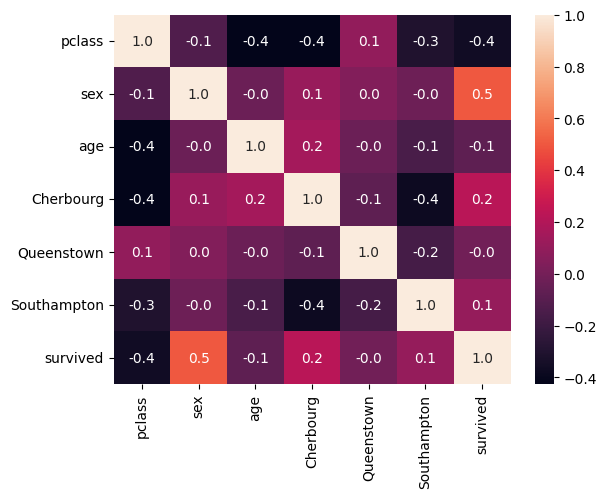

In [19]:
correlations = df.corr()
plot = seaborn.heatmap(correlations, cbar=True, annot=True, fmt=".1f")

Apparently the class of the ticket and the sex of the passenger are most indicative for survivability. Since we choose the value `1` for female and `0` for male, the correlation coefficient of positive `0.5` indicates that when the value for `sex` goes up, survivability also goes up, so females have a higher chance to survive than males. Similarly when the value for `pclass` goes up (and therefore the class goes down, because 1st class is higher than 3rd class) survivability goes down, in other words, 1st class passenger were more likely to survive than other classes. Additionally, passengers that embarked in Cherbourg seem to have a little higher survivability too, which is not easily explained. Surprisingly however, the age does have little influence, which is unexpected because the consensus in case of disaster of that time was that women and children are to be saved first. This is probably why `sex` does correlate well with `survived`, as mentioned before, but does not explain why `age` does not correlate well.

For now, no investigation into age is undertaken but merely the features `pclass`, `sex` and `Cherbourg` are selected to continue.

In [20]:
features = ["pclass", "sex", "Cherbourg"]
target = "survived"

X = df[features]
y = df[target]

## Splitting into train/test



In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

There are in total 1313 observations, of which 1050 are now in the train set, and 263 in the test set.


# Modelling

In [22]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print("Accuracy:", score)

Accuracy: 0.844106463878327


It is possible to ask the decision tree which features it considers import in deciding the outcome and which features it considers less import. The values are fractions which add up to 100%.

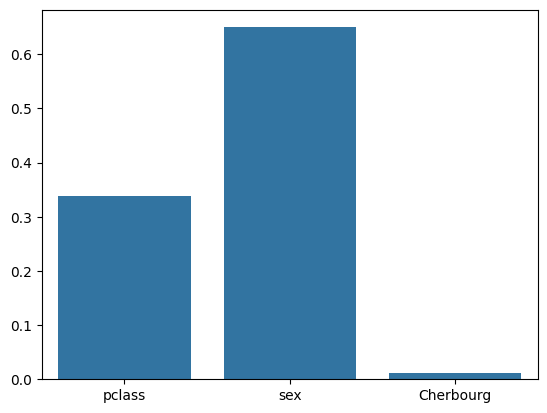

In [23]:
plot = seaborn.barplot(y=model.feature_importances_, x=features)

As expected the feature `sex` has the greatest influence (~65%) on the decision that the tree will take, followed by the feature `pclass` (~33%). The feature `Cherbourg` has very little influence and it is perhaps better eliminated as to reduce the complexity of the model.

The biggest advantage of using a decision tree is that the tree itself can be drawn as to give insight in what actually happens inside the tree. For humans this is an understandable process that greatly improves the transparency of the modelling step.

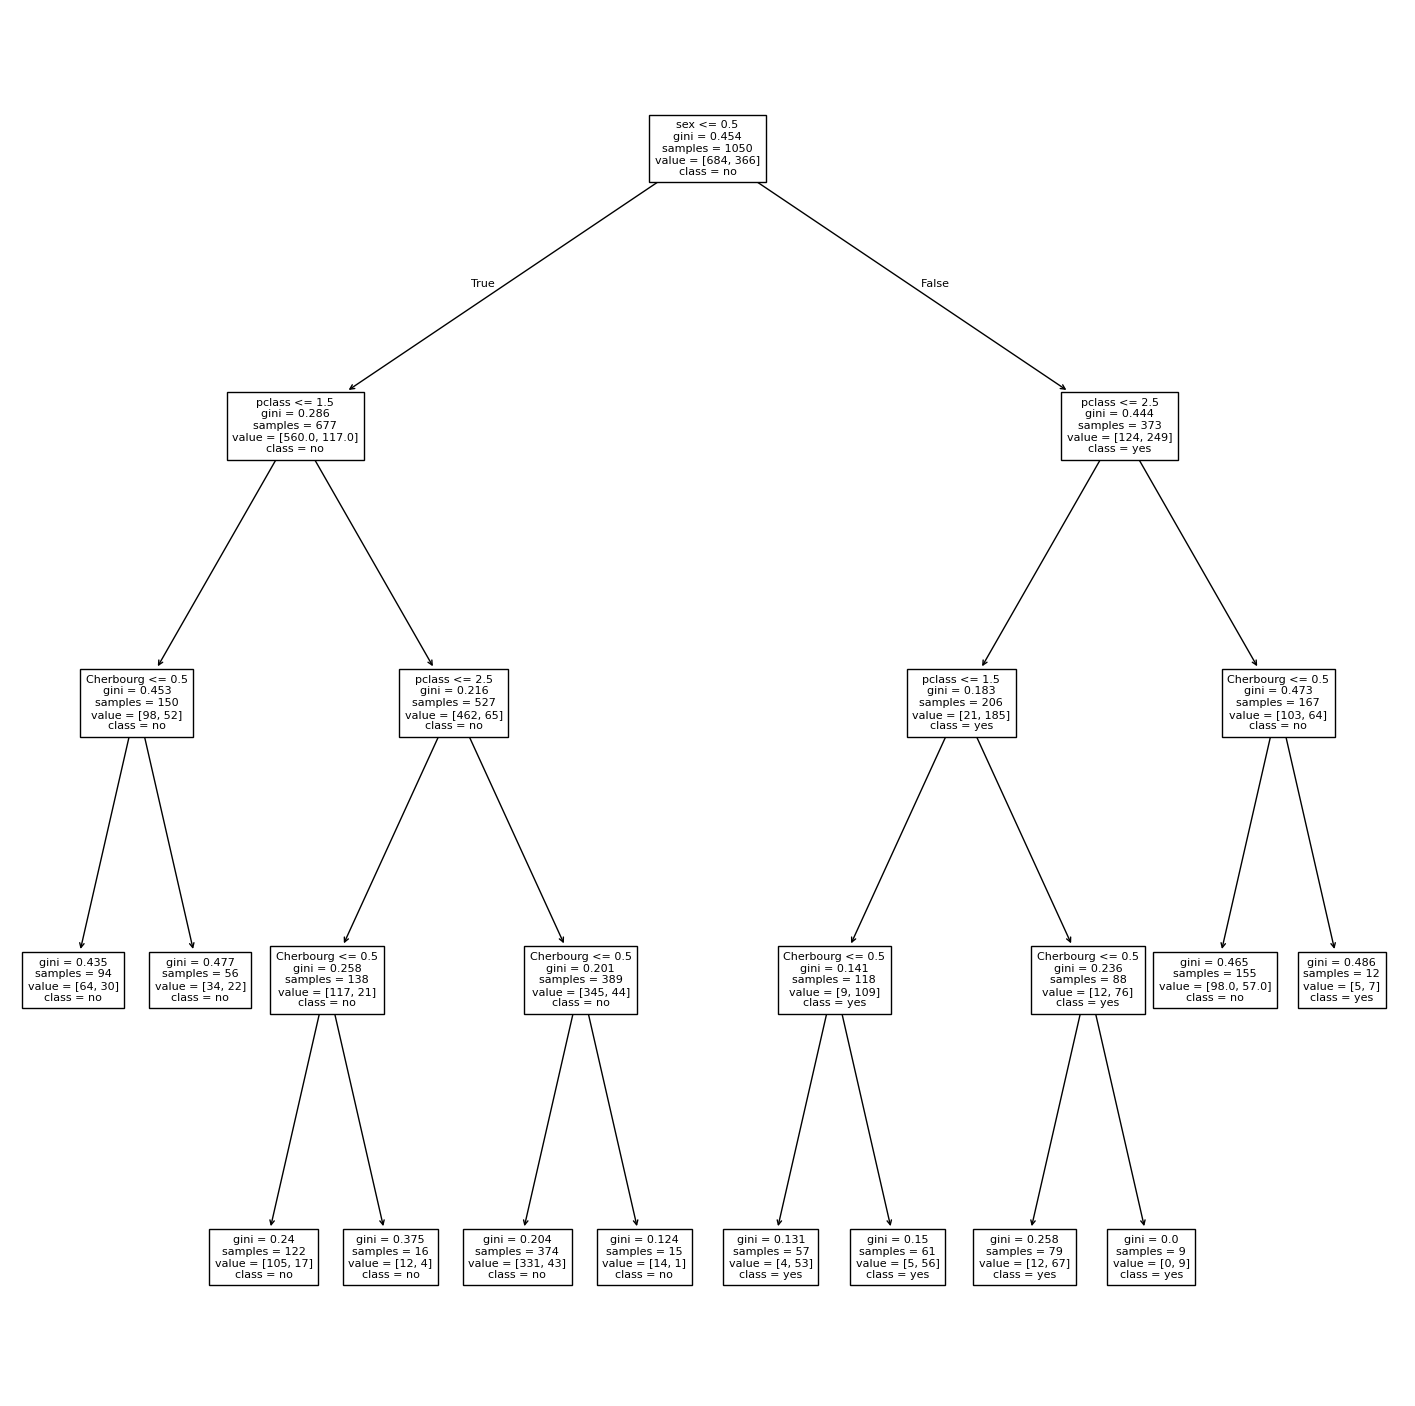

In [24]:
target_names = ["no", "yes"]
import matplotlib.pyplot as plt
plt.figure(figsize=(18,18))
from sklearn.tree import plot_tree
plot_tree(model, fontsize=8, feature_names=features, class_names=target_names)
plt.show()

# Evaluation
This notebook produces slightly different results every time it is ran due to the random train/test split. However, calculating the evaluation metrics for the train set as well as the test set gives us insight in whether the model is overfitted or not. If the trainset results are a lot better than the testset results, it means that the model is trained a little too well on the train set and therefore generalizes badly in the real world.

In [25]:
from sklearn.metrics import classification_report

print("Train set:")
predictions = model.predict(X_train)
report = classification_report(y_train, predictions, target_names=target_names)
print(report)

print("Test set:")
predictions = model.predict(X_test)
report = classification_report(y_test, predictions, target_names=target_names)
print(report)

Train set:
              precision    recall  f1-score   support

          no       0.79      0.96      0.87       684
         yes       0.88      0.52      0.66       366

    accuracy                           0.81      1050
   macro avg       0.84      0.74      0.76      1050
weighted avg       0.82      0.81      0.79      1050

Test set:
              precision    recall  f1-score   support

          no       0.82      0.99      0.90       180
         yes       0.96      0.53      0.68        83

    accuracy                           0.84       263
   macro avg       0.89      0.76      0.79       263
weighted avg       0.86      0.84      0.83       263



Running the notebook a few times one will notice that sometimes the results for the testset are a little different from the trainset, but not greatly so. In conclusion, the model is not overfitted and will generalize well in the real world.

# Inference

Now let us try a few fictionally persons, and see whether they would have survived the Titanic Disaster or not.

First class female, not from Cherbourg.

In [26]:
data = {"pclass": 1, "sex": 1, "Cherbourg": 0}

X_inference = pandas.DataFrame([data])
prediction = model.predict_proba(X_inference)
result = pandas.DataFrame()
result["Outcome"] = target_names
result["Probability"] = prediction[0]
result

,Outcome,Probability
0,no,0.070175
1,yes,0.929825


Second class male, from Cherbourg.

In [27]:
data = {"pclass": 2, "sex": 0, "Cherbourg": 1}

X_inference = pandas.DataFrame([data])
prediction = model.predict_proba(X_inference)
result = pandas.DataFrame()
result["Outcome"] = target_names
result["Probability"] = prediction[0]
result

,Outcome,Probability
0,no,0.75
1,yes,0.25


First class male, from Cherbourg.

In [28]:
data = {"pclass": 1, "sex": 0, "Cherbourg": 1}

X_inference = pandas.DataFrame([data])
prediction = model.predict_proba(X_inference)
result = pandas.DataFrame()
result["Outcome"] = target_names
result["Probability"] = prediction[0]
result

,Outcome,Probability
0,no,0.607143
1,yes,0.392857
